In [146]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
# Load config
import json
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import sys
sys.path.append('../../../utils')
sys.path.append('../../..')

In [148]:
IMAGE_SHAPE = (1000, 1000)
CONFIG_PATH = '../../../config.json'
SPLIT = 'test'
IOU_THRESHOLD = 0.7

In [149]:
N_CLASSES = 2
NO_OBJECT = N_CLASSES

### Получим группы на ленте

In [150]:
from copy import deepcopy
from utils.integrate.integrate import shift_mask
from utils.interpolate.refine_markup_by_yolo import poly, mask_iou, get_box

def align_group(ext_group, shifts):
    ext_group = deepcopy(ext_group)
    for obj in ext_group:
        shift = shifts[obj['img'].name]
        conf = None
        if 'conf' in obj['obj']:
            conf = float(obj['obj']['conf'])
        obj['obj'] = shift_mask(obj['obj'], shift)
        obj['obj']['is_border'] = obj['is_border']
        if conf is not None:
            obj['obj']['conf'] = conf
    return ext_group

def align_groups(ext_group, shifts):
    return [
        align_group(ext_group, shifts)
        for ext_group in ext_group
    ]

### Интерполированный тест

In [151]:
import pickle
import json
def load_groups(pred_groups_path : str, speed_path : str):
    with open(pred_groups_path, 'rb') as f:
        pred_extended_groups = pickle.load(f)
    with open(speed_path) as f:
        speed_dict = json.load(f)
    shifts = {}
    speed_sum = 0
    for k, v in sorted(speed_dict.items(), key=lambda x: x[0]):
        speed_sum += v
        shifts[Path(k).name] = speed_sum
    return align_groups(pred_extended_groups, shifts)

In [152]:
trainval_groups = load_groups(
    pred_groups_path = f'/alpha/projects/wastie/code/kondrashov/delta/groups/pred_groups_trainval.pkl',
    speed_path = f'/alpha/projects/wastie/code/kondrashov/delta/data/trainval/speed.json'
)
test_groups = load_groups(
    pred_groups_path = f'/alpha/projects/wastie/code/kondrashov/delta/notes/pred_24_12_dense_c06.pkl', 
    speed_path = f'../../../data/dense_test/speed.json'
)

In [153]:
# from sklearn.model_selection import train_test_split
# train_groups, val_groups = train_test_split(trainval_groups, test_size=0.15, random_state=42)
# print("Train:", len(train_groups))
# print("Val:", len(val_groups))

### Формирование датасета

In [216]:
from scipy.stats import kurtosis, skew
def generate_stats(data : np.ndarray):
    q3 = np.quantile(data, 0.75)
    q1 = np.quantile(data, 0.25)
    data = data.astype(np.float64)
    return [
        np.mean(data), 
        np.std(data),
        np.min(data),
        np.max(data),
        np.median(data)
    ]

In [217]:
def feat_factory(group : list):
    result = list()
    
    result.append(float(len(group)))
    classes = np.array([int(obj['cls']) for obj in group])
    counts = np.array([(classes == cls).sum() for cls in range(N_CLASSES)])
    ratios = counts / len(group)
    for cls in range(N_CLASSES):
        result.append(counts[cls])
        result.append(ratios[cls])

    boxes = [get_box(obj) for obj in group]
    x1s, y1s, x2s, y2s = map(np.array, zip(*boxes))
    confs = np.array([(obj['conf'] if 'conf' in obj else 1.0) for obj in group])

    hs = (y2s - y1s)
    ws = (x2s - x1s)
    areas = hs * ws
    aspect_ratios = ws / hs

    result.extend(generate_stats(confs))
    result.extend(generate_stats(hs))
    result.extend(generate_stats(ws))
    result.extend(generate_stats(aspect_ratios))
    result.extend(generate_stats(areas))
    return result

In [218]:
def combine_group_features(group_extended : list):
    return feat_factory([o['obj'] for o in group_extended])

In [219]:
def get_label(group):
    valid_labels = [int(obj['obj']['cls']) for obj in group if obj['is_matched']]
    return max(set(valid_labels), key=valid_labels.count) if valid_labels else NO_OBJECT 

In [220]:
X_train = np.stack([combine_group_features(g) for g in trainval_groups])
y_train = np.array([get_label(g) for g in trainval_groups])

In [221]:
X_test = np.stack([combine_group_features(g) for g in test_groups])
y_test = np.array([get_label(g) for g in test_groups])

In [207]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split

class NumpyDataset(Dataset):
    def __init__(self, features, labels):
        """
        Args:
            features (np.ndarray): Матрица признаков (размер: num_samples x num_features)
            labels (np.ndarray): Вектор меток (размер: num_samples)
        """
        super().__init__()
        self.x = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [234]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

BATCH_SIZE = 32
INPUT_DIM = 30  # Размерность признаков (N)
HIDDEN_DIM = 128
NUM_CLASSES = 3
EPOCHS = 10
DATA_SIZE = 1000  # Общее количество примеров

# Модель нейронной сети
class ThreeClassClassifier(pl.LightningModule):
    def __init__(self, input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('test_acc', acc)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [235]:
def prepare_data(trainval_dataset, test_dataset):
    train_len = int(0.85 * len(trainval_dataset))
    val_len = len(trainval_dataset) - train_len
    
    train_ds, val_ds = random_split(
        trainval_dataset, 
        [train_len, val_len],
        generator=torch.Generator().manual_seed(42)
    )
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    return train_loader, val_loader, test_loader

In [236]:
# Инициализация
model = ThreeClassClassifier()
train_dataset = NumpyDataset(X_train, y_train)
test_dataset = NumpyDataset(X_test, y_test)
train_loader, val_loader, test_loader = prepare_data(train_dataset, test_dataset)

# Callbacks для сохранения лучшей модели
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    filename='best_model'
)

# Тренер
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[checkpoint_callback],
    accelerator='auto',
    log_every_n_steps=10
)

# Обучение
trainer.fit(model, train_loader, val_loader)

# Тестирование
trainer.test(model, test_loader, ckpt_path='best')

# Пример предсказания
sample = torch.randn(1, INPUT_DIM)
model.eval()
with torch.no_grad():
    prediction = model(sample).argmax().item()
print(f"\nSample prediction: Class {prediction}")

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | fc1     | Linear           | 4.0 K  | train
1 | fc2     | Linear           | 387    | train
2 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.017     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


/alpha/projects/wastie/code/kondrashov/delta/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/alpha/projects/wastie/code/kondrashov/delta/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 328/328 [00:04<00:00, 65.83it/s, v_num=11, train_loss=20.90, train_acc=0.733, val_loss=21.40, val_acc=0.747] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 328/328 [00:04<00:00, 65.77it/s, v_num=11, train_loss=20.90, train_acc=0.733, val_loss=21.40, val_acc=0.747]


Restoring states from the checkpoint path at /alpha/projects/wastie/code/kondrashov/delta/notes/aggregate/supervised/lightning_logs/version_11/checkpoints/best_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /alpha/projects/wastie/code/kondrashov/delta/notes/aggregate/supervised/lightning_logs/version_11/checkpoints/best_model.ckpt
/alpha/projects/wastie/code/kondrashov/delta/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 43/43 [00:00<00:00, 200.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8179824352264404
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Sample prediction: Class 1


In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report

X_train = np.nan_to_num(X_train, nan=0)
y_train = np.nan_to_num(y_train, nan=0)
X_test = np.nan_to_num(X_test, nan=0)
xgb_model.fit(X_train, y_train)

# Make predictions on test set
y_pred = xgb_model.predict(X_test)

# Calculate macro F1 score
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f'Macro F1 Score: {macro_f1:.4f}')

# Show F1 score for each class
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Macro F1 Score: 0.8263

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       940
           1       0.94      0.84      0.89       103
           2       0.64      0.77      0.70       325

    accuracy                           0.84      1368
   macro avg       0.83      0.83      0.83      1368
weighted avg       0.86      0.84      0.85      1368



In [ ]:
from sklearn.utils import class_weight
#classes_weights = list(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))
class_weights = [0.1, 0.3, 0.6]

weights = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    weights[i] = classes_weights[val]

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1]
}

cat_model = cb.CatBoostClassifier(random_state=42)

grid_search = GridSearchCV(estimator=cat_model, 
                          param_grid=param_grid,
                          cv=5,
                          scoring='f1_macro',
                          n_jobs=10,
                          verbose=2,
                          error_score="raise")

grid_search.fit(X_train, y_train, sample_weight=weights)

# Get best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Update model with best parameters
cat_model = cb.CatBoostClassifier(**grid_search.best_params_)


# Make predictions on test set
cat_model.fit(X_train, y_train, sample_weight=weights)
y_pred = cat_model.predict(X_test)

# Calculate macro F1 score
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f'Macro F1 Score: {macro_f1:.4f}')

# Show F1 score for each class
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0:	learn: 1.0859403	total: 66.2ms	remaining: 13.2s
1:	learn: 1.0736042	total: 70.2ms	remaining: 6.95s
2:	learn: 1.0614318	total: 73.8ms	remaining: 4.85s
3:	learn: 1.0490612	total: 86.6ms	remaining: 4.24s
4:	learn: 1.0372929	total: 89.9ms	remaining: 3.51s
5:	learn: 1.0254738	total: 93.7ms	remaining: 3.03s
6:	learn: 1.0143174	total: 97.4ms	remaining: 2.69s
7:	learn: 1.0032867	total: 101ms	remaining: 2.41s
8:	learn: 0.9922596	total: 104ms	remaining: 2.21s
9:	learn: 0.9820057	total: 111ms	remaining: 2.1s
0:	learn: 1.0859403	total: 53.6ms	remaining: 5.31s
1:	learn: 1.0736042	total: 57.3ms	remaining: 2.81s
10:	learn: 0.9720773	total: 128ms	remaining: 2.19s
2:	learn: 1.0614318	total: 68.7ms	remaining: 2.22s
11:	learn: 0.9623525	total: 140ms	remaining: 2.2s
12:	learn: 0.9524004	total: 144ms	remaining: 2.08s
3:	learn: 1.0490612	total: 85.5ms	remaining: 2.05s
13:	learn: 0.9424447	total: 149ms	remaining: 1.98s
4:	learn: 1.0372929	total

In [ ]:
from src.aggregate.model import ModelClassifier

## Оценка

### Создадим агрегатор

In [237]:
from src.aggregate.base import Aggregator
from src.aggregate.threshold import ThresholdClassifier
from src.aggregate.merge import UnionMerger

In [ ]:
classifier = ModelClassifier(N_CLASSES, lambda x : model(torch.tensor(x, dtype=torch.double)), feat_factory)
gt_classifier = ThresholdClassifier(N_CLASSES, 1)
merger = UnionMerger(N_CLASSES)

In [262]:
aggregator = Aggregator(classifier, merger)
gt_aggregator = Aggregator(gt_classifier, merger)

### Интерполированный тест

In [252]:
import pickle
import json
TEST_NAME = 'dense'
with open(f'/alpha/projects/wastie/code/kondrashov/delta/notes/gt_24_12_dense_c06.pkl', 'rb') as f:
    gt_extended_groups = pickle.load(f)
with open(f'/alpha/projects/wastie/code/kondrashov/delta/notes/pred_24_12_dense_c06.pkl', 'rb') as f:
    pred_extended_groups = pickle.load(f)
with open(f'../../../data/{TEST_NAME}_test/speed.json') as f:
    speed_dict = json.load(f)
    shifts = {}
    speed_sum = 0
    for k, v in sorted(speed_dict.items(), key=lambda x: x[0]):
        speed_sum += v
        shifts[Path(k).name] = speed_sum

### Получим группы на ленте

In [253]:
from copy import deepcopy
import random
from utils.integrate.integrate import shift_mask
from utils.interpolate.refine_markup_by_yolo import poly, mask_iou, get_box

def align_group(ext_group, shifts):
    ext_group = deepcopy(ext_group)
    for obj in ext_group:
        shift = shifts[obj['img'].name]
        obj['obj'] = shift_mask(obj['obj'], shift)
    return ext_group

def align_groups(ext_group, shifts):
    return [
        align_group(ext_group, shifts)
        for ext_group in ext_group
    ]

In [254]:
gt_aligned_groups = align_groups(gt_extended_groups, shifts)
pred_aligned_groups = align_groups(pred_extended_groups, shifts)

In [255]:
gt_groups = [[o['obj'] for o in g] for g in gt_aligned_groups]
pred_groups = [[o['obj'] for o in g]  for g in pred_aligned_groups]

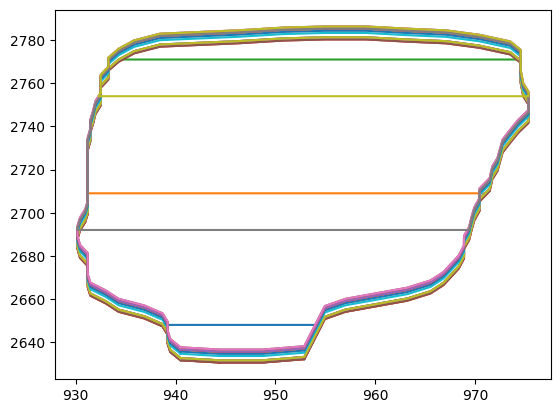

In [256]:
for polygon in map(poly, gt_groups[random.randint(0, len(gt_groups))]):
    x, y = polygon.exterior.xy
    plt.plot(x, y)
plt.show()

### Агрегация

In [263]:
gt = gt_aggregator.aggregate(gt_groups)
pred = aggregator.aggregate(pred_groups)

TypeError: tensor(): argument 'dtype' must be torch.dtype, not str

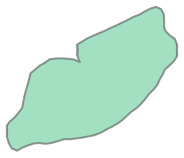

In [ ]:
poly(gt[random.randint(0, len(gt))])

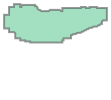

In [ ]:
poly(pred[random.randint(0, len(pred))])

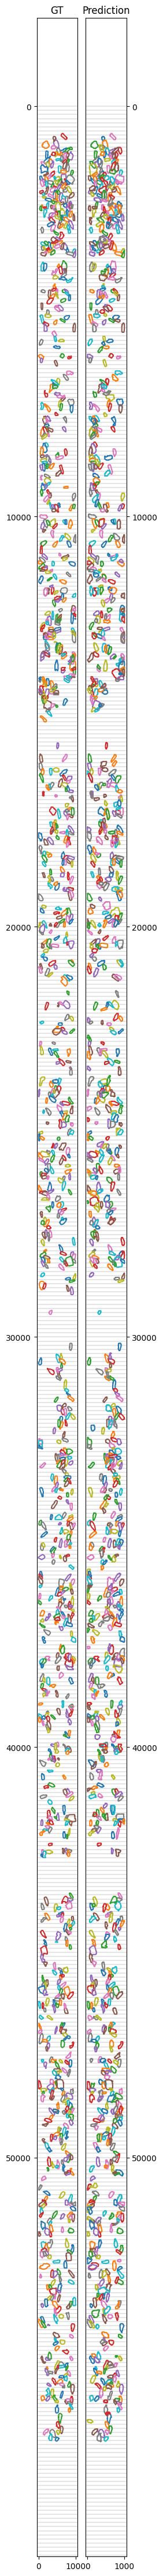

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2, max(shifts.values()) / 1000))

for polygon in map(poly, gt):
    x, y = polygon.exterior.xy
    ax1.plot(x, y)
ax1.invert_yaxis()
ax1.set_title('GT')

for polygon in map(poly, pred):
    x, y = polygon.exterior.xy
    ax2.plot(x, y)
ax2.invert_yaxis()
ax2.set_title('Prediction')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

xlim = (min(ax.get_xlim()[0] for ax in [ax1, ax2]), max(ax.get_xlim()[1] for ax in [ax1, ax2]))
ylim = (min(ax.get_ylim()[0] for ax in [ax1, ax2]), max(ax.get_ylim()[1] for ax in [ax1, ax2]))

for ax in [ax1, ax2]:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


min_ylim = 0
max_ylim = min(ax.get_ylim()[0] for ax in [ax1, ax2])
for ax in [ax1, ax2]:
    step = 100  # Draw line every 100 pixels
    for y in range(int(min_ylim), int(max_ylim), step):
        ax.axhline(y=y, color='gray', alpha=0.2, linestyle='-')

plt.show()

### Метрики

In [ ]:
from tqdm import tqdm 

def boxes_intersect(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Check if one box is to the right of the other
    if x1 + w1 <= x2 or x2 + w2 <= x1:
        return False
        
    # Check if one box is above the other
    if y1 + h1 <= y2 or y2 + h2 <= y1:
        return False
        
    return True

def find_matches(gt : list[dict], pred : list[dict], iou_threshold : float = 0.7):
    gt_boxes = [get_box(t) for t in gt]
    pred_boxes = [get_box(t) for t in pred]

    gt_matches = [False] * len(gt)
    pred_matches = [False] * len(pred)

    for i, gt_obj in tqdm(enumerate(gt), total=len(gt)):
        for j, pred_obj in enumerate(pred):
            if boxes_intersect(gt_boxes[i], pred_boxes[j]):
                iou = mask_iou(gt_obj, pred_obj)
                if iou > iou_threshold:
                    gt_matches[i] = True
                    pred_matches[j] = True
    return np.array(gt_matches), np.array(pred_matches)

In [ ]:
gt_matches, pred_matches = find_matches(gt, pred, IOU_THRESHOLD)

  3%|▎         | 41/1241 [00:00<00:11, 106.06it/s]

100%|██████████| 1241/1241 [00:51<00:00, 24.27it/s]


In [ ]:
gt_matches[[g['cls'] == 1 for g in gt]]

array([ True, False,  True, False,  True, False,  True,  True,  True,  True, False, False,  True, False, False,  True,  True,  True,  True,  True,  True, False, False, False, False,  True,  True,  True, False,  True,  True, False,  True, False,  True, False,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True, False,  True,  True,  True,  True,  True,  True,  True, False,  True, False,  True, False,  True,  True,  True,  True,  True,  True,  True, False,  True,  True,  True,  True, False,  True, False, False,  True,  True,  True,  True, False, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,  True,  True, False,  True, False, False,  True, False,  True,  True, False,  True,  True, False,  True,  True,  True,  True,  True, False, False,  True, False,  True,  True])

In [ ]:
precision = np.mean(pred_matches) if len(pred_matches) > 0 else 0
recall = np.mean(gt_matches) if len(gt_matches) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.6315
Recall: 0.6269
F1 Score: 0.6292


Бутылки

In [ ]:
gm, pm = gt_matches[[g['cls'] == 0 for g in gt]], pred_matches[[g['cls'] == 0 for g in pred]]
precision = np.mean(pm) if len(pm) > 0 else 0
recall = np.mean(gm) if len(gm) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
print("# Bottles #")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Bottles #
Precision: 0.6315
Recall: 0.6202
F1 Score: 0.6258


In [ ]:
gm, pm = gt_matches[[g['cls'] == 1 for g in gt]], pred_matches[[g['cls'] == 1 for g in pred]]
precision = np.mean(pm) if len(pm) > 0 else 0
recall = np.mean(gm) if len(gm) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
print("# Cans #")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Cans #
Precision: 0.0000
Recall: 0.6885
F1 Score: 0.0000


### Оптимальный порог интеграции

In [ ]:
def find_best_threshold(gt_aligned_groups, pred_aligned_groups):
    thresholds = range(1, 17)
    precisions = []
    recalls    = []
    f1_scores  = []

    for threshold in thresholds:
        classifier = ThresholdClassifier(N_CLASSES, threshold)
        merger = UnionMerger(N_CLASSES)
        aggregator = Aggregator(classifier, merger)
        
        pred = aggregator.aggregate(pred_groups)

        gt_matches, pred_matches = find_matches(gt, pred, IOU_THRESHOLD)

        precision = np.mean(pred_matches) if len(pred_matches) > 0 else 0
        recall = np.mean(gt_matches) if len(gt_matches) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
    plt.plot(thresholds, precisions, marker='s', label='Precision')
    plt.plot(thresholds, recalls, marker='^', label='Recall')
    plt.xlabel('Integration Threshold')
    plt.ylabel('Score')
    plt.title(f'Metrics vs Integration Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

    max_f1 = max(f1_scores)
    max_f1_threshold = thresholds[f1_scores.index(max_f1)]
    print(f"Max F1: {max_f1:.3f} at threshold {max_f1_threshold}")

In [ ]:
find_best_threshold(gt_aligned_groups, pred_aligned_groups)

 41%|████▏     | 512/1241 [00:12<00:34, 21.11it/s]

 80%|████████  | 998/1241 [00:42<00:13, 17.82it/s]

 99%|█████████▉| 1232/1241 [00:54<00:00, 22.70it/s]